## Import Lib

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from catboost import Pool, CatBoostClassifier, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report


# This function makes the plot directly on browser
%matplotlib inline

# Setting a figure size 
rcParams['figure.figsize'] = 12, 12

## Import dataset

In [2]:
# Import train dataset
dfTrainOrig = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
# Import test dataset
dfTestOrig = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None
--------------------
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             

<AxesSubplot:>

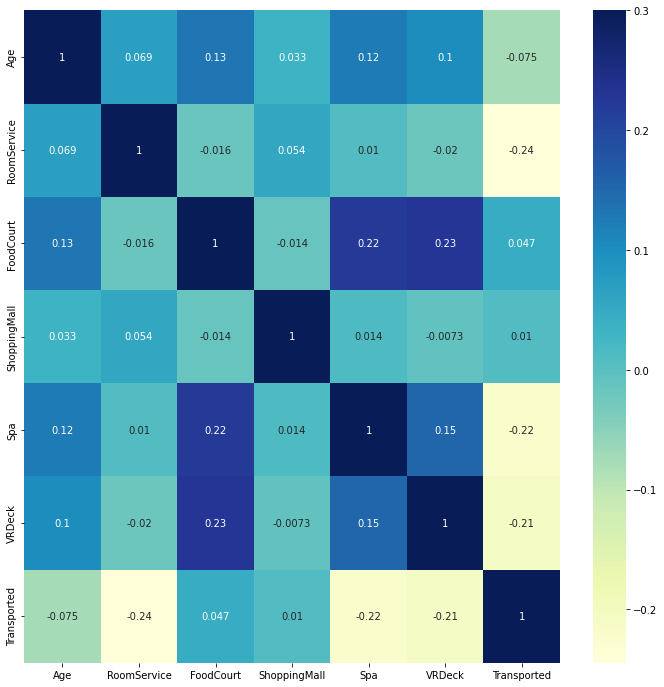

In [3]:
print(dfTrainOrig.info())
print("-"*20)
print(dfTrainOrig.isnull().sum())

sns.heatmap(dfTrainOrig.corr(), vmax=.3, annot=True, cmap="YlGnBu")

In [4]:
print(dfTestOrig.info())
print("-"*70)
print(dfTestOrig.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB
None
----------------------------------------------------------------------
               Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  4186.000000   4195.000000   4171.

## Preprocessing

In [5]:
#Fill nan by mode for caterogical, median for age, mean for float
dfTrain = dfTrainOrig.copy()
dfTrain['HomePlanet'].fillna(dfTrain['HomePlanet'].mode()[0], inplace = True)
dfTrain['CryoSleep'].fillna(dfTrain['CryoSleep'].mode()[0], inplace = True)
dfTrain['Destination'].fillna(dfTrain['Destination'].mode()[0], inplace = True)
dfTrain['Age'].fillna(dfTrain['Age'].median(), inplace = True)
dfTrain['VIP'].fillna(dfTrain['VIP'].mode()[0], inplace = True)
dfTrain['RoomService'].fillna(dfTrain['RoomService'].mean(), inplace = True)
dfTrain['FoodCourt'].fillna(dfTrain['FoodCourt'].mean(), inplace = True)
dfTrain['ShoppingMall'].fillna(dfTrain['ShoppingMall'].mean(), inplace = True)
dfTrain['Spa'].fillna(dfTrain['Spa'].mean(), inplace = True)
dfTrain['VRDeck'].fillna(dfTrain['VRDeck'].mean(), inplace = True)

#Drop extra column
columnToDrop = ['PassengerId', 'Name']
dfTrain.drop(columnToDrop, axis=1, inplace = True)

# dfTrain.dropna(axis = 0, inplace = True)


print(dfTrain.info())
print("-"*70)
print(dfTrain.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   object 
 1   CryoSleep     8693 non-null   bool   
 2   Cabin         8494 non-null   object 
 3   Destination   8693 non-null   object 
 4   Age           8693 non-null   float64
 5   VIP           8693 non-null   bool   
 6   RoomService   8693 non-null   float64
 7   FoodCourt     8693 non-null   float64
 8   ShoppingMall  8693 non-null   float64
 9   Spa           8693 non-null   float64
 10  VRDeck        8693 non-null   float64
 11  Transported   8693 non-null   bool   
dtypes: bool(3), float64(6), object(3)
memory usage: 636.8+ KB
None
----------------------------------------------------------------------
HomePlanet        0
CryoSleep         0
Cabin           199
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt   

In [6]:
numRowsTrain = dfTrain.shape[0]
dfAll = dfTrain.append(dfTestOrig, ignore_index = True)
print(dfAll.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    12883 non-null  object 
 1   CryoSleep     12877 non-null  object 
 2   Cabin         12671 non-null  object 
 3   Destination   12878 non-null  object 
 4   Age           12879 non-null  float64
 5   VIP           12877 non-null  object 
 6   RoomService   12888 non-null  float64
 7   FoodCourt     12864 non-null  float64
 8   ShoppingMall  12872 non-null  float64
 9   Spa           12869 non-null  float64
 10  VRDeck        12890 non-null  float64
 11  Transported   8693 non-null   object 
 12  PassengerId   4277 non-null   object 
 13  Name          4183 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.4+ MB
None


In [7]:
#unpack Desk, Cabin and Side from cabin
CabinAll = dfAll['Cabin'].copy()
Desk, Cabin, Side = [], [], []

for CabinToSide in CabinAll:
    if type(CabinToSide) == float:
        Desk.append(None)
        Cabin.append(None)
        Side.append(None)
    else:
        Desk.append(CabinToSide[0])
        Cabin.append(CabinToSide[2:-2])
        Side.append(CabinToSide[-1])

dfAllCabin = dfAll.drop('Cabin', axis = 1).copy()
dfAllCabin['Desk'] = Desk
dfAllCabin['Cabin'] = Cabin
dfAllCabin['Side'] = Side

In [8]:
#Encoder for 'LabeltoEncode[]'. Over from last call - dfAllCabin
le = LabelEncoder()
LabeltoEncode = ['Side', 'Cabin', 'Desk', 'CryoSleep', 'VIP', 'Transported', 'HomePlanet', 'Destination']
dfAllCabEncode = dfAllCabin[{'Age', 'RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'}]

#each colums of 'LabeltoEncode[]' go to encoder, then add to dfAllCabEncode
for column in LabeltoEncode:
    colToEncode = dfAllCabin[column].to_numpy()
    colEncode = le.fit(colToEncode).transform(colToEncode)
    dfAllCabEncode[column] = colEncode

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [9]:
print(dfAllCabEncode.info())
print("-"*70)
print(dfAllCabEncode.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RoomService   12888 non-null  float64
 1   VRDeck        12890 non-null  float64
 2   FoodCourt     12864 non-null  float64
 3   Spa           12869 non-null  float64
 4   ShoppingMall  12872 non-null  float64
 5   Age           12879 non-null  float64
 6   Side          12970 non-null  int64  
 7   Cabin         12970 non-null  int64  
 8   Desk          12970 non-null  int64  
 9   CryoSleep     12970 non-null  int64  
 10  VIP           12970 non-null  int64  
 11  Transported   12970 non-null  int64  
 12  HomePlanet    12970 non-null  int64  
 13  Destination   12970 non-null  int64  
dtypes: float64(6), int64(8)
memory usage: 1.4 MB
None
----------------------------------------------------------------------
        RoomService        VRDeck     FoodCourt           Spa  ShoppingMall  

In [10]:
#Back separation of dataset: to train and test (after preprocessing)
dfTrain = dfAllCabEncode[:numRowsTrain]
dfTest = dfAllCabEncode[numRowsTrain:]

In [11]:
print(dfTrain.info())
print("-"*70)
print(dfTrain.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RoomService   8693 non-null   float64
 1   VRDeck        8693 non-null   float64
 2   FoodCourt     8693 non-null   float64
 3   Spa           8693 non-null   float64
 4   ShoppingMall  8693 non-null   float64
 5   Age           8693 non-null   float64
 6   Side          8693 non-null   int64  
 7   Cabin         8693 non-null   int64  
 8   Desk          8693 non-null   int64  
 9   CryoSleep     8693 non-null   int64  
 10  VIP           8693 non-null   int64  
 11  Transported   8693 non-null   int64  
 12  HomePlanet    8693 non-null   int64  
 13  Destination   8693 non-null   int64  
dtypes: float64(6), int64(8)
memory usage: 950.9 KB
None
----------------------------------------------------------------------
        RoomService        VRDeck     FoodCourt           Spa  ShoppingMall  

In [12]:
print(dfTest.info())
print("-"*70)
print(dfTest.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 8693 to 12969
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   RoomService   4195 non-null   float64
 1   VRDeck        4197 non-null   float64
 2   FoodCourt     4171 non-null   float64
 3   Spa           4176 non-null   float64
 4   ShoppingMall  4179 non-null   float64
 5   Age           4186 non-null   float64
 6   Side          4277 non-null   int64  
 7   Cabin         4277 non-null   int64  
 8   Desk          4277 non-null   int64  
 9   CryoSleep     4277 non-null   int64  
 10  VIP           4277 non-null   int64  
 11  Transported   4277 non-null   int64  
 12  HomePlanet    4277 non-null   int64  
 13  Destination   4277 non-null   int64  
dtypes: float64(6), int64(8)
memory usage: 467.9 KB
None
----------------------------------------------------------------------
        RoomService        VRDeck     FoodCourt           Spa  ShoppingMa

## Split data

In [13]:
#Split train dataset to data to fit and cross validation
X = dfTrain.drop('Transported', axis=1)
y = dfTrain.Transported

xtrain, xtest, ytrain, ytest = train_test_split(X, y, 
                                               train_size=.80, 
                                               random_state=420, 
                                               stratify=y)

## Make model and fit

In [14]:
#Try XGBoost
from xgboost import XGBClassifier

xgbClass = XGBClassifier(random_state=420, 
                    n_estimators=50, 
                    max_depth=5,
                    learning_rate=0.01, 
                    objective='binary:logistic', 
                    tree_method="hist")

xgbClass.fit(xtrain, ytrain, 
             eval_set=[(xtrain, ytrain), (xtest, ytest)],
             verbose = 0)

xgbpreds = xgbClass.predict(xtest)
print(f'the test accuracy is :{accuracy_score(ytest, xgbClass.predict(xtest)):.3f}')
print(classification_report(ytest,xgbpreds))

the test accuracy is :0.777
              precision    recall  f1-score   support

           0       0.81      0.73      0.76       863
           1       0.75      0.83      0.79       876

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739



<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

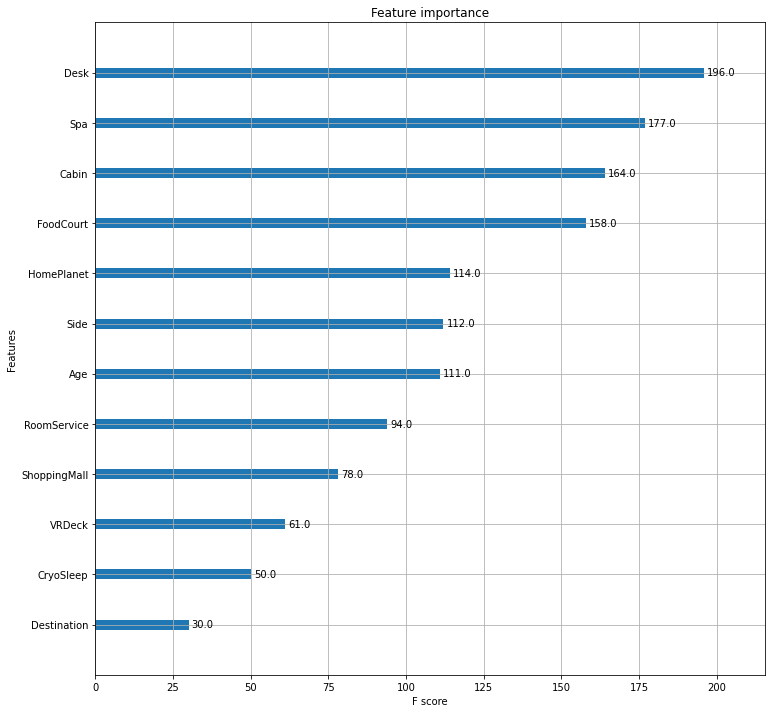

In [15]:
import xgboost as xgb
xgb.plot_importance(xgbClass)

In [16]:
#Try CatBoost
CatBoost = CatBoostClassifier(iterations=5000, 
                           eval_metric='Accuracy',
                           learning_rate=0.01, 
                           verbose = 0,
                           random_seed=420)

CatBoost.fit(xtrain, ytrain, 
             eval_set=[(xtrain, ytrain), (xtest, ytest)])

CatBPreds = CatBoost.predict(xtest)
print(f'the test accuracy is :{accuracy_score(ytest, CatBPreds):.3f}')
print(classification_report(ytest,CatBPreds))

the test accuracy is :0.806
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       863
           1       0.80      0.83      0.81       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



In [17]:
#Try XGB Random Fosest Classifier
from xgboost import XGBRFClassifier

xgbForClass = XGBRFClassifier(random_state=420, 
                    n_estimators=50, 
                    max_depth=5,
                    learning_rate=1, 
                    objective='binary:logistic', 
                    tree_method="hist")

xgbForClass.fit(xtrain, ytrain, 
#              eval_metric='Accuracy',
             eval_set=[(xtrain, ytrain), (xtest, ytest)],
             verbose = 0)

xgbFpreds = xgbForClass.predict(xtest)
print(f'the test accuracy is :{accuracy_score(ytest, xgbFpreds):.3f}')
print(classification_report(ytest,xgbFpreds))

the test accuracy is :0.784
              precision    recall  f1-score   support

           0       0.82      0.73      0.77       863
           1       0.76      0.84      0.80       876

    accuracy                           0.78      1739
   macro avg       0.79      0.78      0.78      1739
weighted avg       0.79      0.78      0.78      1739



## Submit
Best model is CatBoost

In [18]:
pred = CatBoost.predict(dfTest)
pred = pred.astype(int)
submission = pd.DataFrame({'PassengerId':dfTestOrig['PassengerId'],'Survived':pred})
submission.to_csv('submission.csv',index=False)